### Import packages

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import dill
import yaml
import numpy as np
import pandas as pd
import ast

import seaborn as sns
sns.set(style='ticks')

### Import submodular-optimization packages

In [2]:
sys.path.insert(0, "/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/submodular_optimization/")

### Visualizations directory

In [3]:
VIZ_DIR = os.path.abspath("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/submodular_optimization/viz/")

### Plotting utilities

In [4]:
def set_style():
    # This sets reasonable defaults for font size for a paper
    sns.set_context("paper")    
    # Set the font to be serif
    sns.set(font='serif')#, rc={'text.usetex' : True})   
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    # Set tick size for axes
    sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})

In [5]:
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()

In [6]:
def save_fig(fig, filename):
    fig.savefig(os.path.join(VIZ_DIR, filename), dpi=600, format='pdf', bbox_inches='tight')

### Plots

In [7]:
df = pd.read_csv("/Users/smnikolakaki/GitHub/submodular-linear-cost-maximization/jupyter/experiment_02.csv",
                header=0,
                index_col=False)

df.columns = ['Algorithm', 'sol', 'val', 'submodular_val', 'cost', 'runtime', 'lazy_epsilon',
       'sample_epsilon','user_sample_ratio','scaling_factor','num_rare_skills','num_common_skills',
        'num_popular_skills','num_sampled_skills','seed','k']

#### Details

Algorithms:

1. Distorted Greedy: (1 - 1/e) approximation of submodular func value with dynamic weights on submodular func
2. Stochastic Distorted Greedy: (1 - 1/e - eps) approximation of submodular func value. It is distorted greedy with sampling
3. Cost Scaled Greedy: (1/2) approximation of submodular func value with constant weights (2) on cost func
4. Cost Scaled Exact Lazy Greedy: Cost Scaled Greedy with exact lazy evaluation
5. Scaled Single Threshold Greedy: (1/2)(3-sqrt(5)) approximation of submodular value with constant weights (1/2(3+sqrt(5)) on cost func

Total Num users: 4564
Total Num skills: 1639

#### Performance comparison

In [8]:
def plot_performance_comparison(df):
    ax = sns.lineplot(x='k', y='val', data=df, hue='Algorithm', ci='sd')
    plt.xlabel('k')
    plt.ylabel('Value of objective function')
    plt.title('Performance comparison')
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

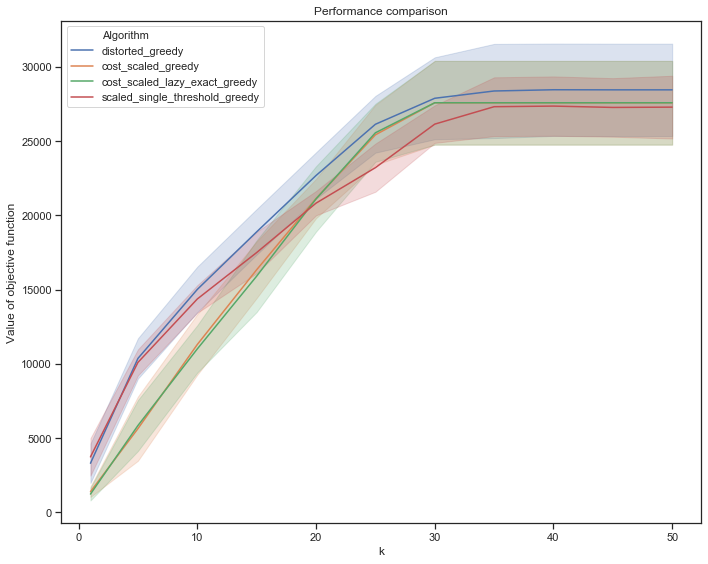

In [9]:
df = df[(df.Algorithm == 'distorted_greedy')
        |(df.Algorithm == 'stochastic_distorted_greedy')
        |(df.Algorithm == 'cost_scaled_greedy')
        |(df.Algorithm == 'cost_scaled_lazy_exact_greedy')
        |(df.Algorithm == 'scaled_single_threshold_greedy')
    ]
df = df[(df['user_sample_ratio'] == 0.4)]
df0 = df[(df['sample_epsilon'].isnull()) | (df['sample_epsilon'] == 0.15)]

set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, 10, 8)

#### Runtime comparison

In [10]:
def plot_performance_comparison(df):
    ax = sns.lineplot(x='k', y='runtime', data=df, hue='Algorithm', ci='sd')
    plt.xlabel('k')
    plt.ylabel('Time (sec)')
    plt.title('Performance comparison')
    plt.yscale('log')
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

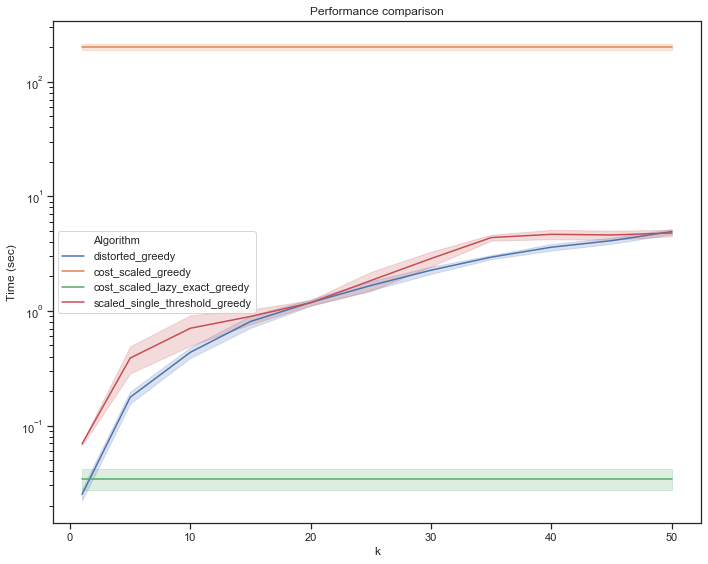

In [11]:
df = df[(df.Algorithm == 'distorted_greedy')
        |(df.Algorithm == 'stochastic_distorted_greedy')
        |(df.Algorithm == 'cost_scaled_greedy')
        |(df.Algorithm == 'cost_scaled_lazy_exact_greedy')
        |(df.Algorithm == 'scaled_single_threshold_greedy')
    ]
df = df[(df['user_sample_ratio'] == 0.4)]
df0 = df[(df['sample_epsilon'].isnull()) | (df['sample_epsilon'] == 0.15)]

set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, 10, 8)

In [12]:
def plot_performance_comparison(df):
    ax = sns.lineplot(x='sample_epsilon', y='val', data=df, hue='Algorithm', ci='sd')
    plt.xlabel('eps')
    plt.ylabel('Value of objective function')
    plt.title('Performance comparison')
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

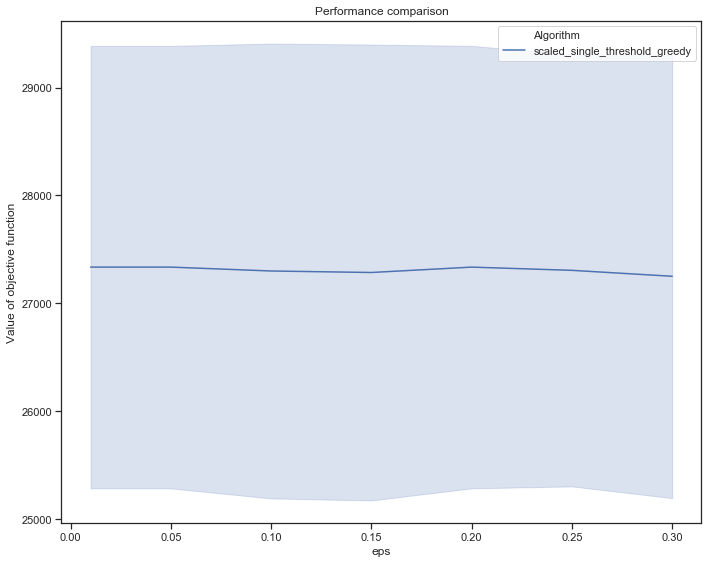

In [13]:
df = df[(df.Algorithm == 'scaled_single_threshold_greedy')
    ]
df = df[(df['user_sample_ratio'] == 0.4)]
df0 = df[(df['k'] == 50)]

set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, 10, 8)

In [14]:
def plot_performance_comparison(df):
    ax = sns.lineplot(x='sample_epsilon', y='runtime', data=df, hue='Algorithm', ci='sd')
    plt.xlabel('eps')
    plt.ylabel('Value of objective function')
    plt.title('Performance comparison')
    fig = plt.gcf()
    ax = plt.gca()
    return fig, ax

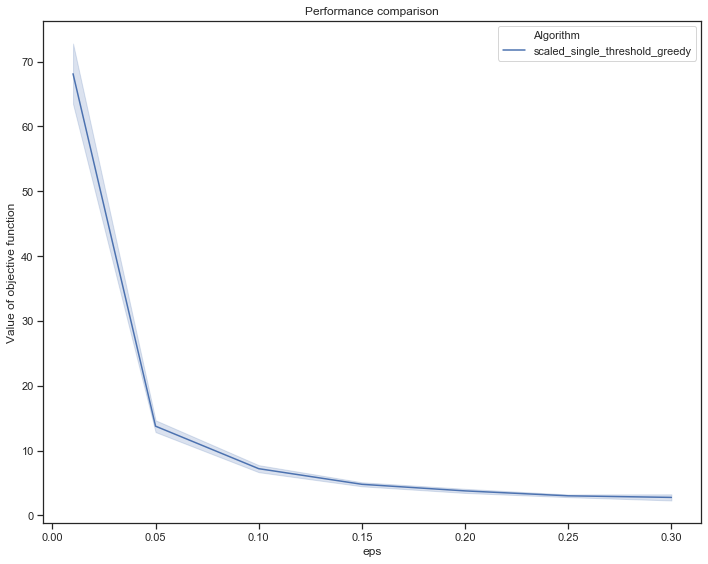

In [15]:
df = df[(df.Algorithm == 'scaled_single_threshold_greedy')
    ]
df = df[(df['user_sample_ratio'] == 0.4)]
df0 = df[(df['k'] == 50)]

set_style()
fig, axes = plot_performance_comparison(df0)
set_size(fig, 10, 8)